In this notebook analysis the porcentage of False Positive that were classify as slum and the feature 'prop_ocupado' is lower than 50% and runs a Kmeans with the variables ('D1_012_p', 'D1_017_p', 'D1_035_p', 'D1_044_p', "esp_1", 'area_count', "area_mean", "DCL_mean") to understand the level slums precarity 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns



import time
from joblib import Memory

In [2]:

DEFAULT_CRS = "EPSG:4326"


In [3]:
#Open the file data/generate/WGS84_hex_sp_model_sempitu.gpkg with GeoPandas
 
# Open the file
fp = "data/generated/WGS84_hex_sp_model_all.gpkg"
data = gpd.read_file(fp, crs=DEFAULT_CRS)





In [5]:
var = [
    'Households connected to water supply network (%)',
    'Households connected to sewerage system (%)',
    'Households solid waste collection (%)',
    'Number of private residences',
    'Number of buildings areas',
    "Average building area",
    "Average slope"]


In [6]:
DEFAULT_CRS = "EPSG:4326"
RANDOM_STATE = 42

In [7]:
# analysis the porcentage of False Positive(variavle model1_result as FP) that were classify as slum and the feature 'prop_ocupado' is lower than 50%

# Select the rows where the model1_result is False Positive
FP = data.loc[data['model1_result'] == 'FP']

# Select the rows where the model1_result is False Positive and the prop_ocupado is lower than 50%
FP_slum = FP.loc[(FP['prop_ocupado'] < 0.5) & (FP['prop_ocupado'] >= 0.1)]

# Calculate the percentage of False Positive that were classified as slum
percentage_FP_slum = len(FP_slum) / len(FP) * 100

print('The percentage of False Positive that were classified as slum and the prop_ocupado is lower than 50% is: ', percentage_FP_slum, '%')


The percentage of False Positive that were classified as slum and the prop_ocupado is lower than 50% is:  48.54092526690392 %


<Axes: xlabel='prop_ocupado', ylabel='is_fav_prob_model1'>

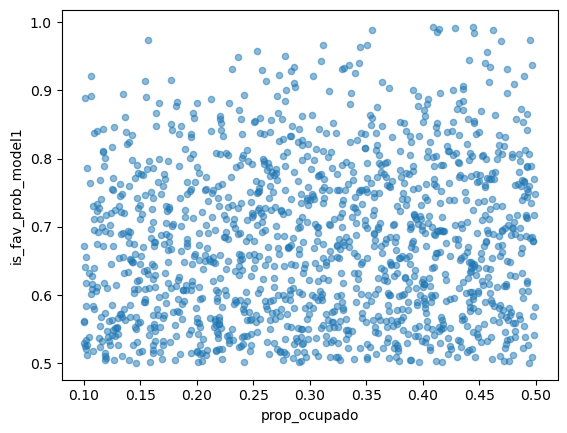

In [8]:
# Make a scatter plot of  prop_ocupado and is_fav_prob_model1

# Create a scatter plot
FP_slum.plot.scatter(x='prop_ocupado', y='is_fav_prob_model1', alpha=0.5)





# Cluster

In [9]:
# Função para aplicar K-means, KMedoids (scikit-learn-extra) com amostragem e mostrar tempo de execução
def compare_clustering_algorithms_with_elbow(data, k_range=(2, 10), sample_size=None, if_scaled_data=True):
    # Se uma amostra for especificada, selecioná-la
    if sample_size:
        if isinstance(data, pd.DataFrame):
            data_sampled = data.sample(n=sample_size, random_state=RANDOM_STATE, replace=True)
        else:
            indices = np.random.choice(data.shape[0], sample_size, replace=False)
            data_sampled = data[indices]
    else:
        data_sampled = data
    
    
    if if_scaled_data:
        # Padronizar os dados
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data_sampled)
    else:
        scaled_data=data_sampled
    
    # Armazenar os resultados
    silhouette_scores_kmeans = []
    nmi_scores_kmeans = []
    inertia_kmeans = []  # For Elbow method
        
    k_values = list(range(k_range[0], k_range[1] + 1))
    
    # Testar diferentes valores de K
    for k in k_values:
        print(f"Processing K={k}...")
        start_time = time.time()
        
        # KMeans
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, init="random", n_init=1000)
        cluster_labels_kmeans = kmeans.fit_predict(scaled_data)
        silhouette_avg_kmeans = silhouette_score(scaled_data, cluster_labels_kmeans)
        silhouette_scores_kmeans.append(silhouette_avg_kmeans)
        
        # Inertia for KMeans (for Elbow Method)
        inertia_kmeans.append(kmeans.inertia_)
  
        # Calcular o tempo de execução
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"K={k} processed in {elapsed_time:.2f} seconds.")
    
    # Plotar o coeficiente de silhueta e Elbow Method para KMeans e KMedoids
    plt.figure(figsize=(14, 10))
    
    # Silhouette Score Plot
    plt.subplot(3, 1, 1)
    plt.plot(k_values, silhouette_scores_kmeans, 'bo-', color='blue', label='KMeans Silhouette Score')
    #plt.plot(k_values, silhouette_scores_kmedoids_sklearn, 'go-', color='green', label='KMedoids Silhouette Score')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Silhouette Coefficient')
    plt.title('Silhouette Coefficient for KMeans and KMedoids (scikit-learn)')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    
    # Elbow Method Plot
    plt.subplot(3, 1, 2)
    plt.plot(k_values, inertia_kmeans, 'bo-', label='KMeans Inertia (Elbow)')
    #plt.plot(k_values, inertia_kmedoids_sklearn, 'go-', label='KMedoids Total Cost (Elbow)')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia / Total Cost')
    plt.title('Elbow Method for KMeans and KMedoids (scikit-learn)')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    best_k_kmeans_silhouette = k_values[np.argmax(silhouette_scores_kmeans)]



    
    return {
        'KMeans': {
            'best_k_kmeans_silhouette': best_k_kmeans_silhouette,
            'inertia': inertia_kmeans
        }
    }

In [10]:
def best_kmeans(data, best_k, if_scaled_data=True):

    if if_scaled_data:
        # Padronizar os dados
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
    else:
        scaled_data=data
    
    # Treinar o KMeans com o melhor K
    best_kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=RANDOM_STATE, init="random", n_init=1000)
    #using kmeans because the results are litter better
    best_kmeans.fit(scaled_data)
    
    # Retornar os centróides e rótulos do cluster
    centroids = scaler.inverse_transform(best_kmeans.cluster_centers_) if if_scaled_data else best_kmeans.cluster_centers_ # Desescalonar para os valores originais 
    return centroids, best_kmeans.labels_


## FP_slum

Processing K=2...
K=2 processed in 2.72 seconds.
Processing K=3...
K=3 processed in 2.13 seconds.
Processing K=4...
K=4 processed in 2.15 seconds.
Processing K=5...
K=5 processed in 2.03 seconds.
Processing K=6...
K=6 processed in 2.11 seconds.
Processing K=7...
K=7 processed in 2.02 seconds.
Processing K=8...
K=8 processed in 2.10 seconds.
Processing K=9...
K=9 processed in 2.04 seconds.
Processing K=10...
K=10 processed in 2.12 seconds.


/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_31573/2642827256.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores_kmeans, 'bo-', color='blue', label='KMeans Silhouette Score')


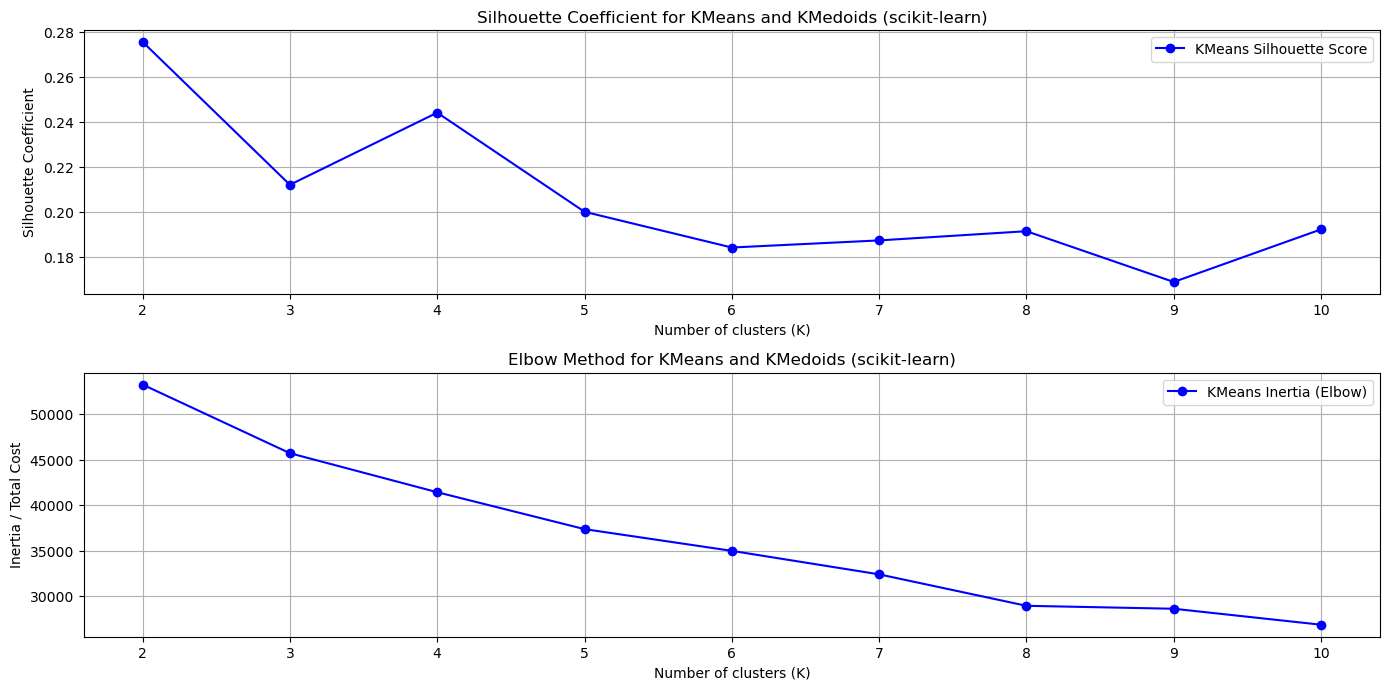

In [11]:
bests  = compare_clustering_algorithms_with_elbow(FP_slum[var], k_range=(2, 10), sample_size=10000)

In [12]:
centroids, labels = best_kmeans(FP_slum[var], 4)

In [13]:
# Pretty show the centroids

centroids_df = pd.DataFrame(centroids, columns=var)
centroids_df


,Households connected to water supply network (%),Households connected to sewerage system (%),Households solid waste collection (%),Number of private residences,Number of buildings areas,Average building area,Average slope
0,0.993283,0.896874,0.987728,197.759295,153.433234,58.864109,16.094156
1,0.725839,0.321070,0.956064,41.511198,51.132425,54.134322,9.389779
2,0.977413,0.648088,0.989074,79.816877,84.352652,66.701124,7.046570
3,0.989126,0.733084,0.991910,150.710690,151.826599,56.271725,5.687765


In [14]:

# add the labels in FP_slum
FP_slum['cluster'] = labels



/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
aux = {key: ['mean', 'std'] for key in var}
aux['id_hex'] = 'count'  # Add count for the number of rows in each cluster

agg = (
    FP_slum.groupby('cluster').agg(
        aux
    ).reset_index()
)
agg

cluster Households connected to water supply network (%)            \
                                                      mean       std   
0       0                                         0.993817  0.025204   
1       1                                         0.717840  0.177110   
2       2                                         0.975841  0.035536   
3       3                                         0.989253  0.024422   

  Households connected to sewerage system (%)            \
                                         mean       std   
0                                    0.887947  0.103603   
1                                    0.326628  0.211434   
2                                    0.624448  0.249312   
3                                    0.752985  0.165960   

  Households solid waste collection (%)            \
                                   mean       std   
0                              0.987527  0.030940   
1                              0.954954  0.077723   
2                              0.988842  0.023242   
3                              0.992325  0.014513   

  Number of private residences            Number of buildings areas  \
                          mean        std                      mean   
0                   196.912863  57.563241                154.082988   
1                    39.901235  42.950438                 49.456790   
2                    76.589499  42.035796                 81.902148   
3                   150.683246  41.959569                149.916230   

             Average building area            Average slope            id_hex  
         std                  mean        std          mean        std  count  
0  28.431582             58.758238   8.210717     16.640110   5.109531    482  
1  31.367598             54.314539  16.042324      9.003200  10.537961     81  
2  28.362106             66.441698  12.393980      7.495054   7.789141    419  
3  25.953993             56.785887   6.816073      4.779176   5.588741    382

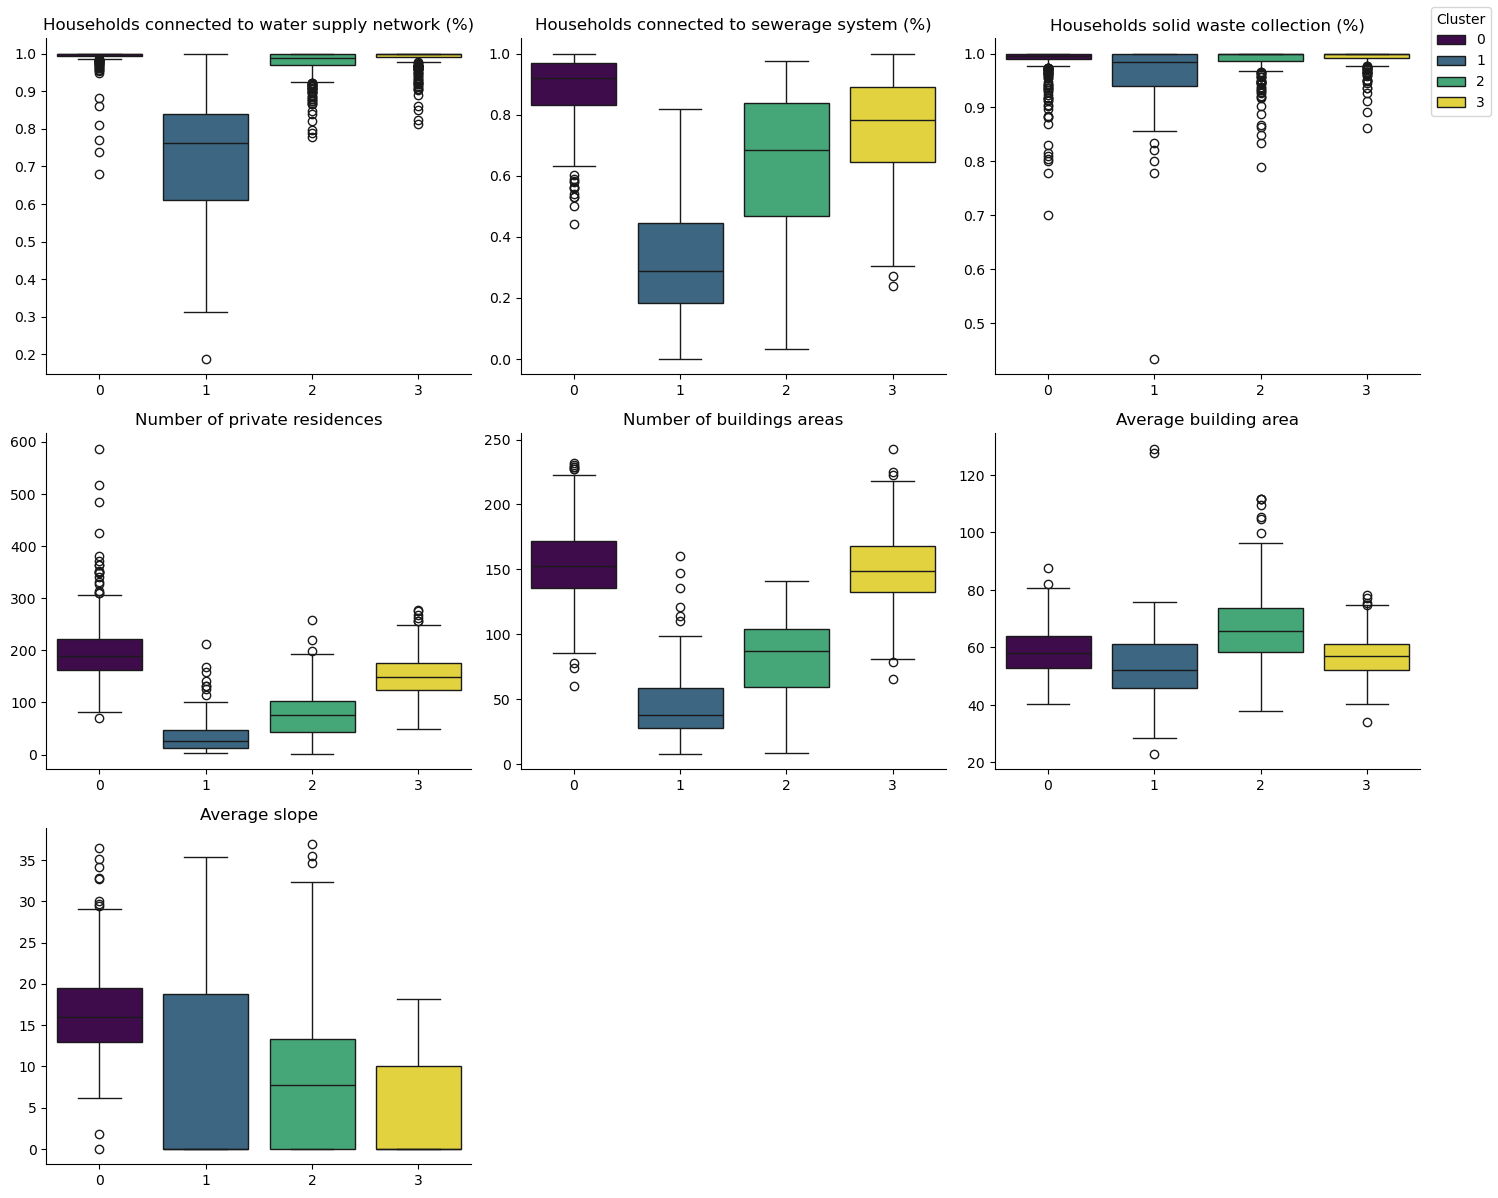

In [38]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


# Creating subplots for each variable
def plot_boxplot_by_cluster(data, var,  cluster_col='cluster'):


    n_vars = len(var)
    n_cols = 3  # You can adjust this number to change the number of columns
    n_rows = int(np.ceil(n_vars / n_cols))

    # Creating subplots for each variable
    fig = plt.figure(figsize=(5*n_cols, 4*n_rows))


    for i, col in enumerate(var, 1):
        ax = fig.add_subplot(n_rows, n_cols, i)
        sns.boxplot(
            data=data, y=col,
            x=cluster_col,
            ax=ax,
            hue=cluster_col,
            palette='viridis',
           )
        
        
        ax.set_title(f'{col}')
        ax.set_xlabel('')  # Remove x label as it's redundant
        ax.set_ylabel('')  # Remove x label as it's redundant
        simpleaxis(ax)
        
        # Remove individual legends
        if ax.get_legend() is not None:
            ax.get_legend().remove()


     # Add a single legend to the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', title='Cluster')


    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Adjust the layout to make room for the legend
    plt.subplots_adjust(right=0.95)
    plt.show()

plot_boxplot_by_cluster(FP_slum, var)


## Cluster for all Positives

In [17]:
# apply the same analysis for FP and P values 
df_postives = data.loc[(data['model1_result'] == 'FP') | (data['model1_result'] == 'P')]



In [66]:
df_postives[var].describe()

,Households connected to water supply network (%),Households connected to sewerage system (%),Households solid waste collection (%),Number of private residences,Number of buildings areas,Average building area,Average slope
count,5902.000000,5902.000000,5902.000000,5902.000000,5902.000000,5902.000000,5902.000000
mean,0.942611,0.699390,0.982405,130.789224,120.368858,61.124480,10.624533
std,0.150784,0.289448,0.060701,89.765446,50.117418,13.059789,9.348868
min,0.000000,0.000000,0.000000,1.000000,3.000000,20.496125,0.000000
25%,0.971429,0.521901,0.987342,61.000000,83.000000,52.605702,0.000000
50%,0.994924,0.808358,1.000000,123.000000,126.000000,59.626137,11.222302
75%,1.000000,0.935173,1.000000,181.000000,157.000000,67.378348,16.863951
max,1.000000,1.000000,1.000000,962.000000,260.000000,190.625620,52.850592


Processing K=2...
K=2 processed in 2.02 seconds.
Processing K=3...
K=3 processed in 1.94 seconds.
Processing K=4...
K=4 processed in 2.17 seconds.
Processing K=5...
K=5 processed in 2.03 seconds.
Processing K=6...
K=6 processed in 2.14 seconds.
Processing K=7...
K=7 processed in 2.06 seconds.
Processing K=8...
K=8 processed in 2.21 seconds.
Processing K=9...
K=9 processed in 2.02 seconds.
Processing K=10...
K=10 processed in 2.13 seconds.


/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_31573/2642827256.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores_kmeans, 'bo-', color='blue', label='KMeans Silhouette Score')


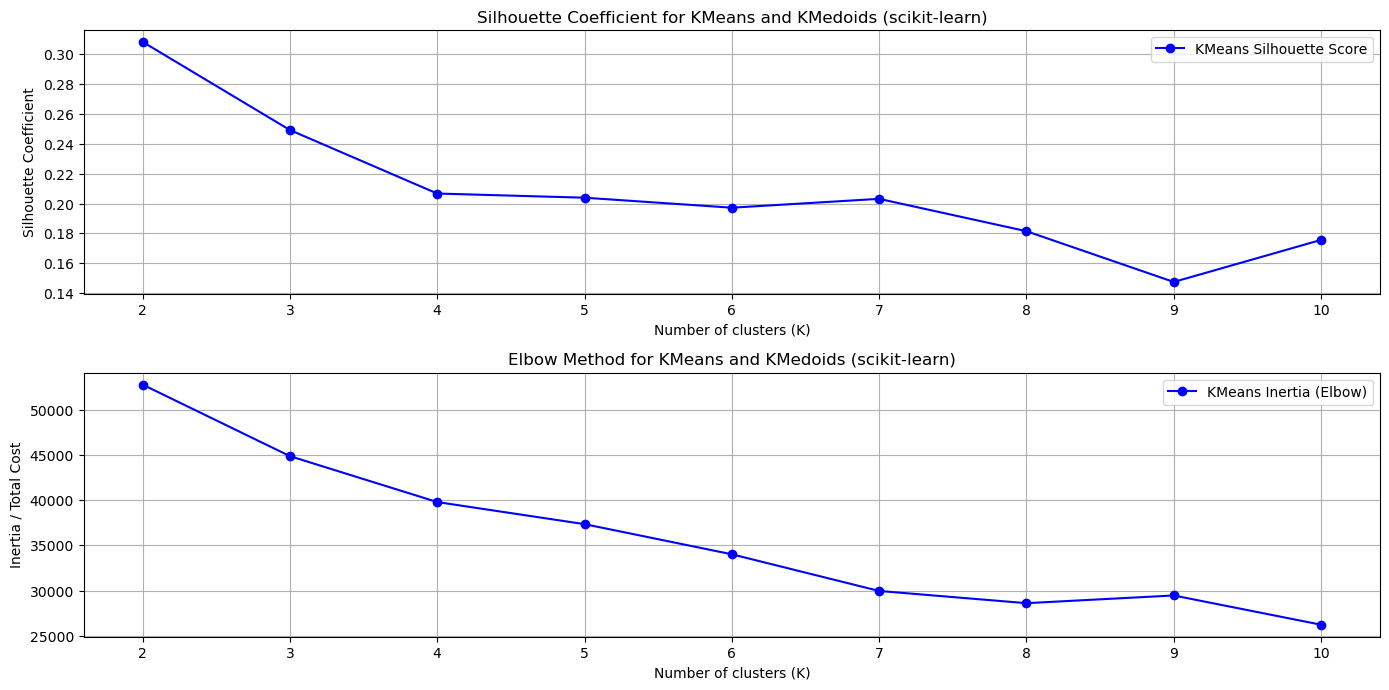

In [18]:
bests_positives  = compare_clustering_algorithms_with_elbow(df_postives[var], k_range=(2, 10), sample_size=10000)

In [49]:
centroids, labels = best_kmeans(df_postives[var], 5)

In [50]:
# add 1 to all labels
labels = labels + 1

In [51]:
# add the labels in FP_slum
df_postives['cluster'] = labels

/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [60]:
aux = {key: ['median', 'mean', 'std'] for key in var}


In [64]:
false_positive_by_cluster = df_postives[df_postives['model1_result'] == 'FP'].groupby('cluster').agg({'id_hex': 'count'})
positive_by_cluster = df_postives[df_postives['model1_result'] == 'P'].groupby('cluster').agg({'id_hex': 'count'})
all_cluster = df_postives.groupby('cluster').agg({'id_hex': 'count'})
# join false_positive_by_cluster and positive_by_cluster
# calculate the percentage of false positive and positve in each cluster
false_positive_by_cluster['percentage'] = false_positive_by_cluster['id_hex'] / all_cluster['id_hex'] * 100
positive_by_cluster['percentage'] = positive_by_cluster['id_hex'] / all_cluster['id_hex'] * 100 



#calculate the percentage of item in each cluster (id_hex) bt the total of itens
all_cluster['percentage'] = all_cluster['id_hex'] / all_cluster['id_hex'].sum() * 100



false_positive_by_cluster.join(positive_by_cluster, lsuffix='_FP', rsuffix='_P').join(all_cluster, rsuffix='_all')



,id_hex_FP,percentage_FP,id_hex_P,percentage_P,id_hex,percentage
cluster,,,,,,
1,294,36.888331,503,63.111669,797,13.503897
2,650,48.076923,702,51.923077,1352,22.907489
3,994,55.811342,787,44.188658,1781,30.176211
4,67,21.824104,240,78.175896,307,5.201627
5,805,48.348348,860,51.651652,1665,28.210776


In [54]:

agg = (
    df_postives.groupby('cluster').agg(
        aux
    ).reset_index()
)
#agg['false_positive_by_cluster']  = false_positive_by_cluster
agg

cluster Households connected to water supply network (%)            \
                                                    median      mean   
0       1                                         1.000000  0.993524   
1       2                                         0.967742  0.931909   
2       3                                         0.993377  0.980950   
3       4                                         0.400000  0.383044   
4       5                                         1.000000  0.989096   

            Households connected to sewerage system (%)                      \
        std                                      median      mean       std   
0  0.025290                                    0.941799  0.869490  0.165187   
1  0.091510                                    0.385079  0.404694  0.249559   
2  0.040439                                    0.851064  0.806951  0.159214   
3  0.202460                                    0.111111  0.152079  0.150827   
4  0.037381                                    0.908163  0.843124  0.171604   

  Households solid waste collection (%)                      \
                                 median      mean       std   
0                              1.000000  0.991054  0.024486   
1                              1.000000  0.984300  0.034696   
2                              1.000000  0.988430  0.026673   
3                              0.976744  0.898301  0.212125   
4                              1.000000  0.985790  0.037049   

  Number of private residences                         \
                        median        mean        std   
0                        243.0  272.099122  97.196591   
1                         40.0   47.691568  35.339554   
2                        113.0  111.083661  44.875774   
3                         34.0   51.179153  47.057438   
4                        166.0  166.380781  49.533209   

  Number of buildings areas                        Average building area  \
                     median        mean        std                median   
0                     161.0  161.752823  30.304906             58.804479   
1                      60.0   62.515533  29.087475             66.366252   
2                     121.0  120.420550  33.199330             61.751791   
3                      66.0   74.990228  43.456423             52.479805   
4                     155.0  155.848649  32.796043             55.425222   

                        Average slope                       id_hex  
        mean        std        median       mean        std  count  
0  59.417067   9.705010     10.355784   9.526719   6.502341    797  
1  68.299052  17.734065     12.079136  11.368838   9.003289   1352  
2  62.512580  10.129151      0.000000   2.918988   4.925296   1781  
3  54.690315  16.007164      9.225187  10.714509  11.856645    307  
4  55.817496   8.153428     17.709766  18.771445   6.412410   1665

In [55]:
# Transpose the description for better readability
description_transposed = agg.transpose()

# Set pandas display options to show more rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the transposed description
description_transposed

0  \
cluster                                                    1.000000   
Households connected to water supply network (%) median    1.000000   
                                                 mean      0.993524   
                                                 std       0.025290   
Households connected to sewerage system (%)      median    0.941799   
                                                 mean      0.869490   
                                                 std       0.165187   
Households solid waste collection (%)            median    1.000000   
                                                 mean      0.991054   
                                                 std       0.024486   
Number of private residences                     median  243.000000   
                                                 mean    272.099122   
                                                 std      97.196591   
Number of buildings areas                        median  161.000000   
                                                 mean    161.752823   
                                                 std      30.304906   
Average building area                            median   58.804479   
                                                 mean     59.417067   
                                                 std       9.705010   
Average slope                                    median   10.355784   
                                                 mean      9.526719   
                                                 std       6.502341   
id_hex                                           count   797.000000   

                                                                   1  \
cluster                                                     2.000000   
Households connected to water supply network (%) median     0.967742   
                                                 mean       0.931909   
                                                 std        0.091510   
Households connected to sewerage system (%)      median     0.385079   
                                                 mean       0.404694   
                                                 std        0.249559   
Households solid waste collection (%)            median     1.000000   
                                                 mean       0.984300   
                                                 std        0.034696   
Number of private residences                     median    40.000000   
                                                 mean      47.691568   
                                                 std       35.339554   
Number of buildings areas                        median    60.000000   
                                                 mean      62.515533   
                                                 std       29.087475   
Average building area                            median    66.366252   
                                                 mean      68.299052   
                                                 std       17.734065   
Average slope                                    median    12.079136   
                                                 mean      11.368838   
                                                 std        9.003289   
id_hex                                           count   1352.000000   

                                                                   2  \
cluster                                                     3.000000   
Households connected to water supply network (%) median     0.993377   
                                                 mean       0.980950   
                                                 std        0.040439   
Households connected to sewerage system (%)      median     0.851064   
                                                 mean       0.806951   
                                                 std        0.159214   
Households solid waste collection (%)            median 

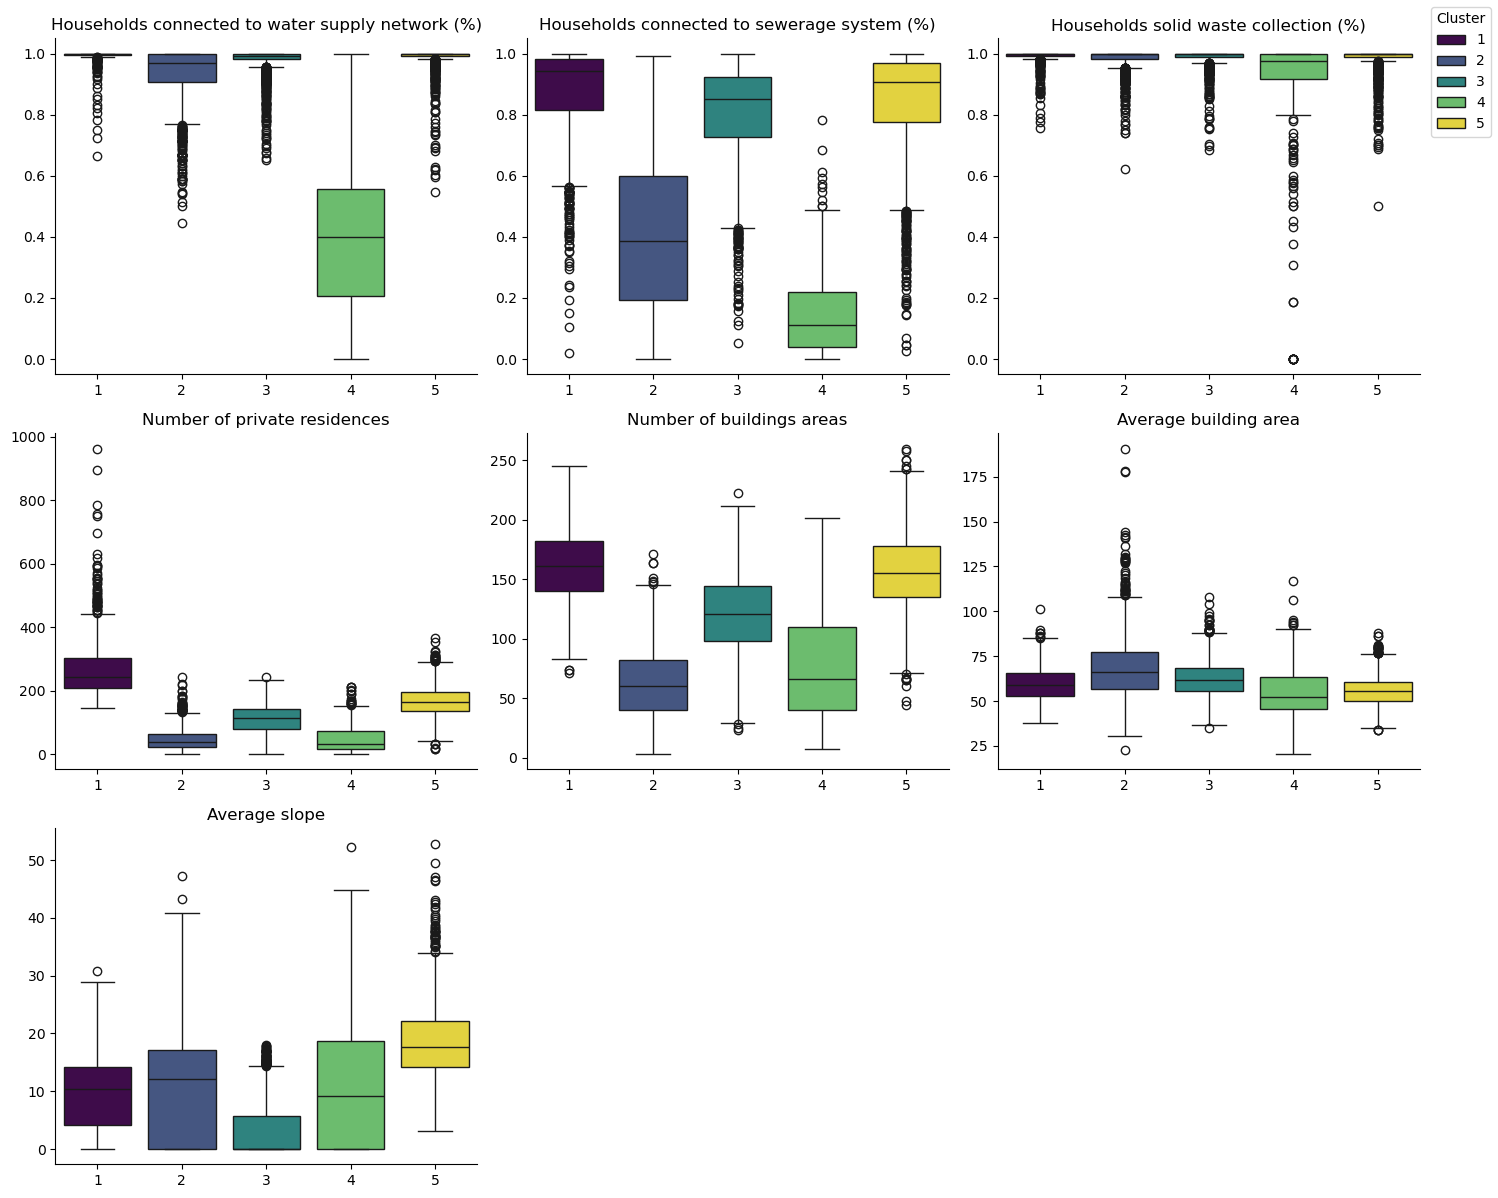

In [56]:
plot_boxplot_by_cluster(df_postives, var)


<Axes: >

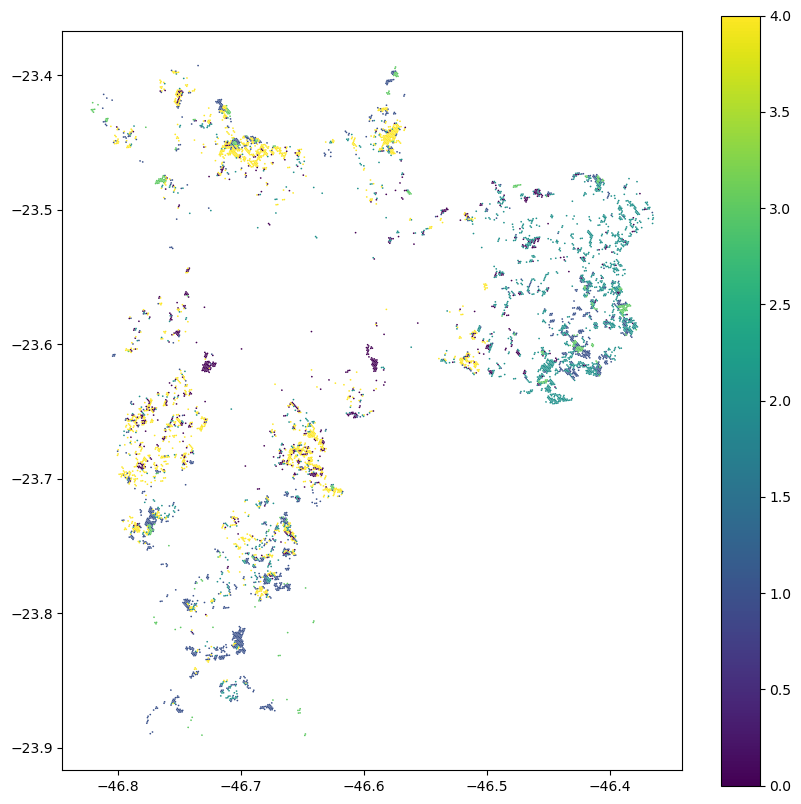

In [26]:
df_postives.plot(column='cluster', legend=True, figsize=(10, 10), cmap='viridis')

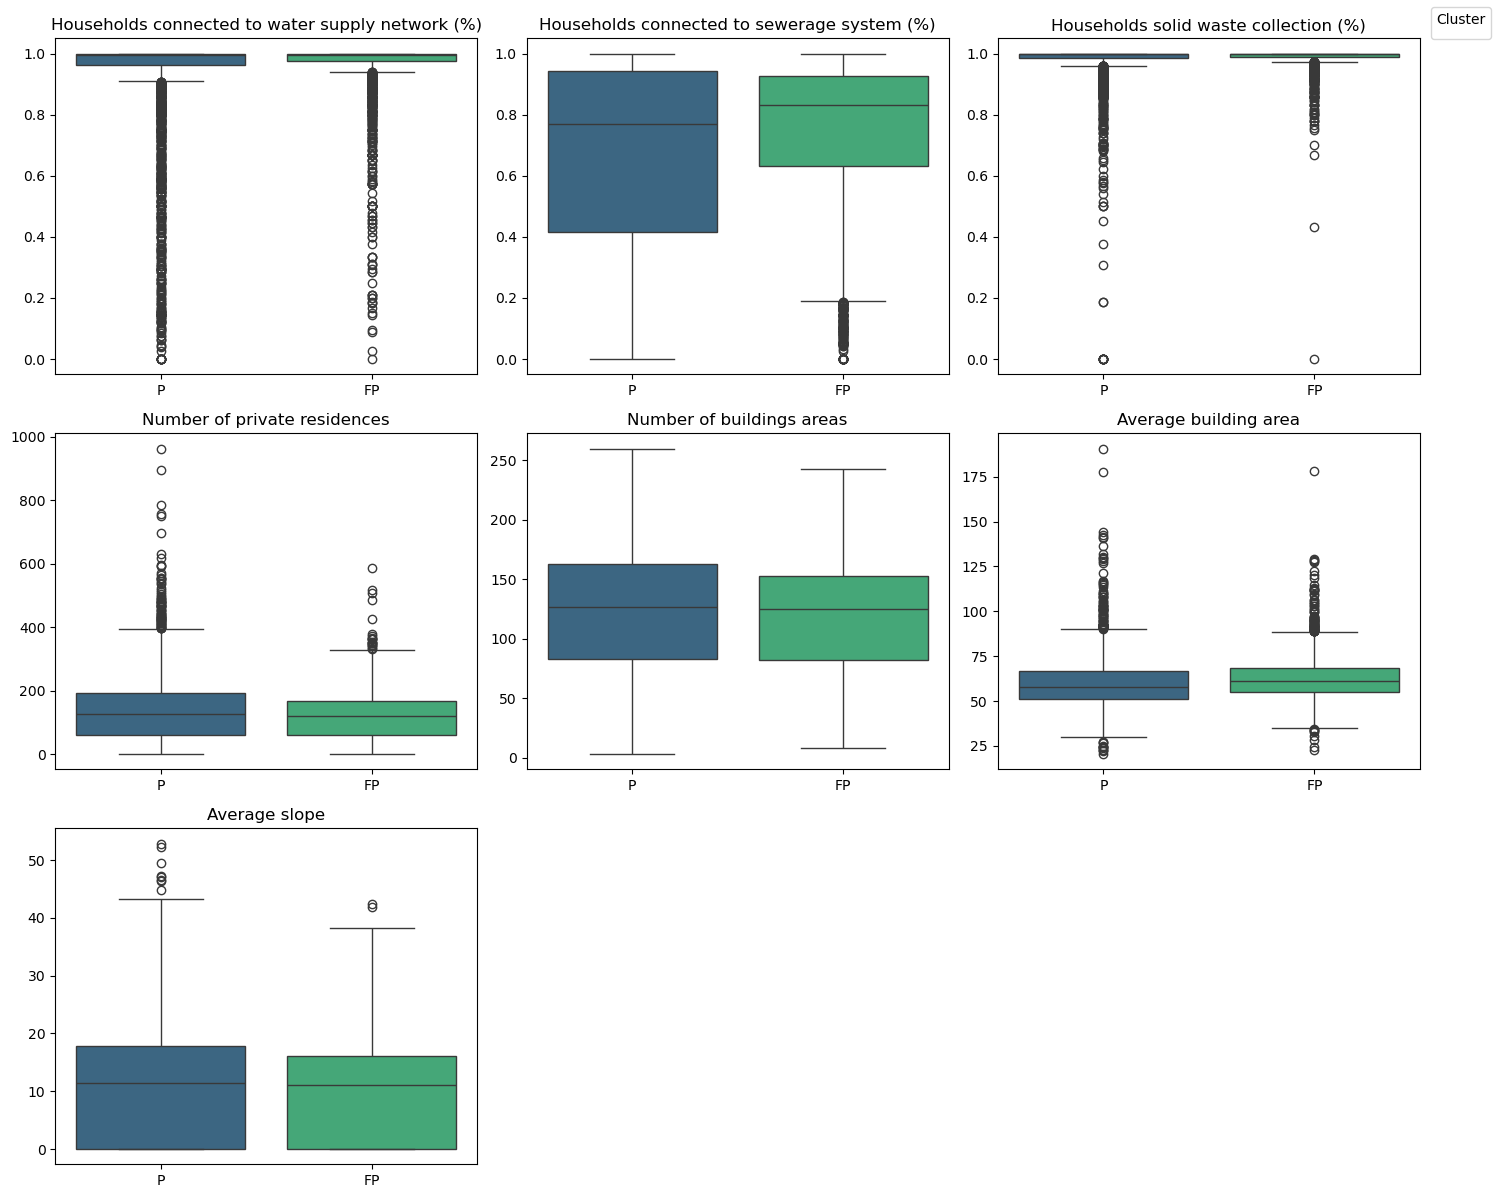

In [27]:
plot_boxplot_by_cluster(df_postives, var, 'model1_result')


# Falso Negativo

Processing K=2...
K=2 processed in 2.07 seconds.
Processing K=3...
K=3 processed in 1.90 seconds.
Processing K=4...
K=4 processed in 2.11 seconds.
Processing K=5...
K=5 processed in 2.05 seconds.
Processing K=6...
K=6 processed in 2.13 seconds.
Processing K=7...
K=7 processed in 2.05 seconds.
Processing K=8...
K=8 processed in 2.14 seconds.
Processing K=9...
K=9 processed in 2.03 seconds.
Processing K=10...
K=10 processed in 2.14 seconds.


/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_31573/2642827256.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores_kmeans, 'bo-', color='blue', label='KMeans Silhouette Score')


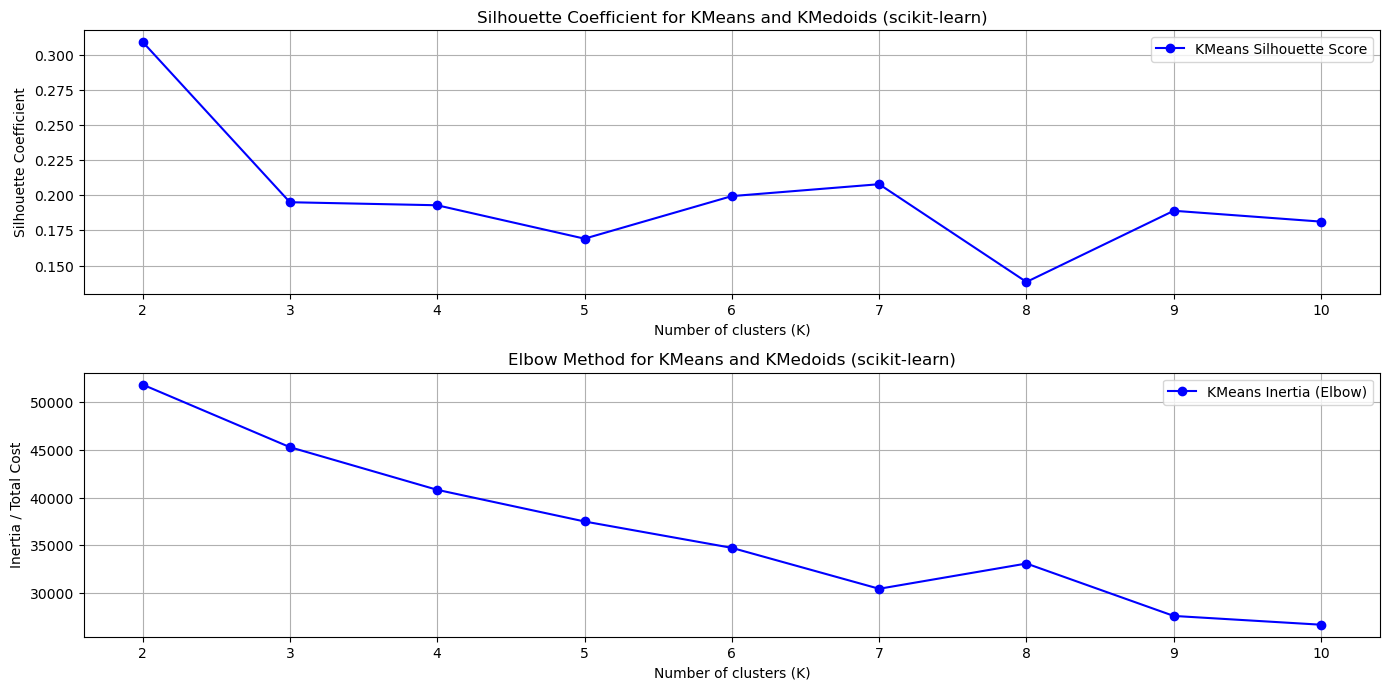

In [28]:
# run the cluster, the boxplot equal runned early, but now for ['model1_result'] == 'FP'
df_postives_FP = df_postives[df_postives['model1_result'] == 'FP']

bests_positives_FP  = compare_clustering_algorithms_with_elbow(df_postives_FP[var], k_range=(2, 10), sample_size=10000) 

/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


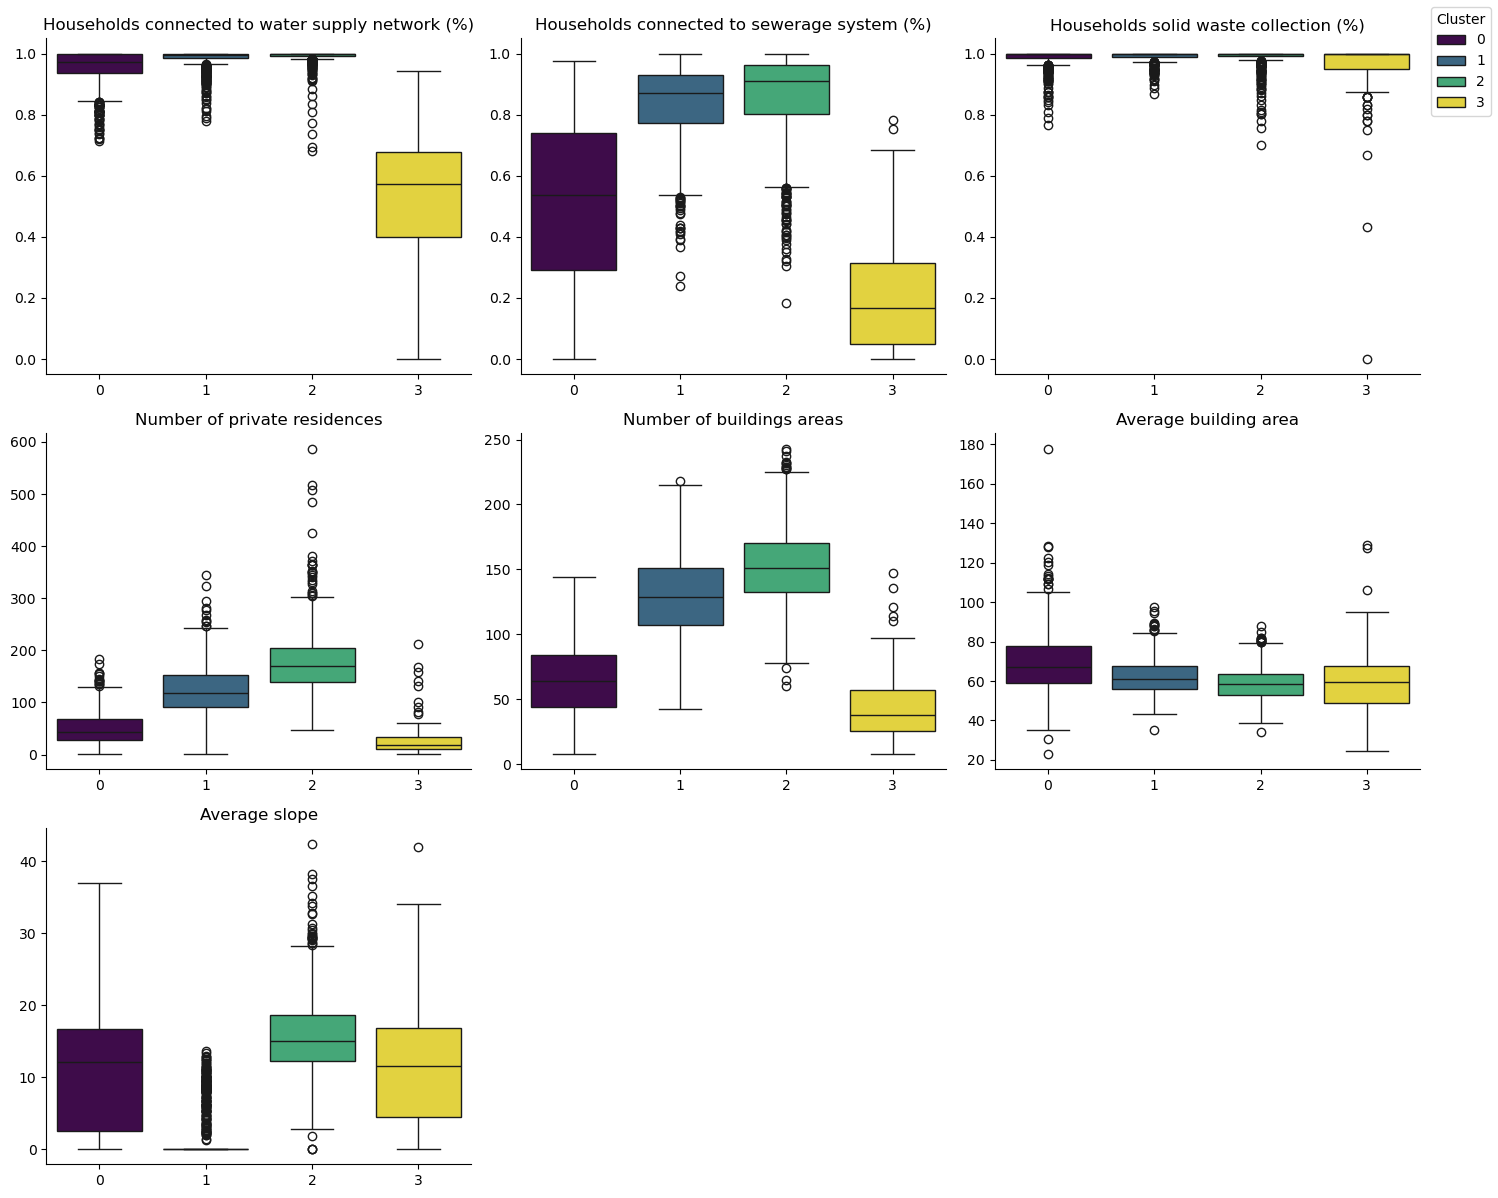

In [41]:


centroids, labels = best_kmeans(df_postives_FP[var], 4)

# add the labels in FP_slum
df_postives_FP['cluster'] = labels

aux = {key: ['mean', 'std'] for key in var}
aux['id_hex'] = 'count'  # Add count for the number of rows in each cluster

agg = (
    df_postives_FP.groupby('cluster').agg(
        aux
    ).reset_index()
)
agg

plot_boxplot_by_cluster(df_postives_FP, var)



In [30]:
df_postives_FP.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

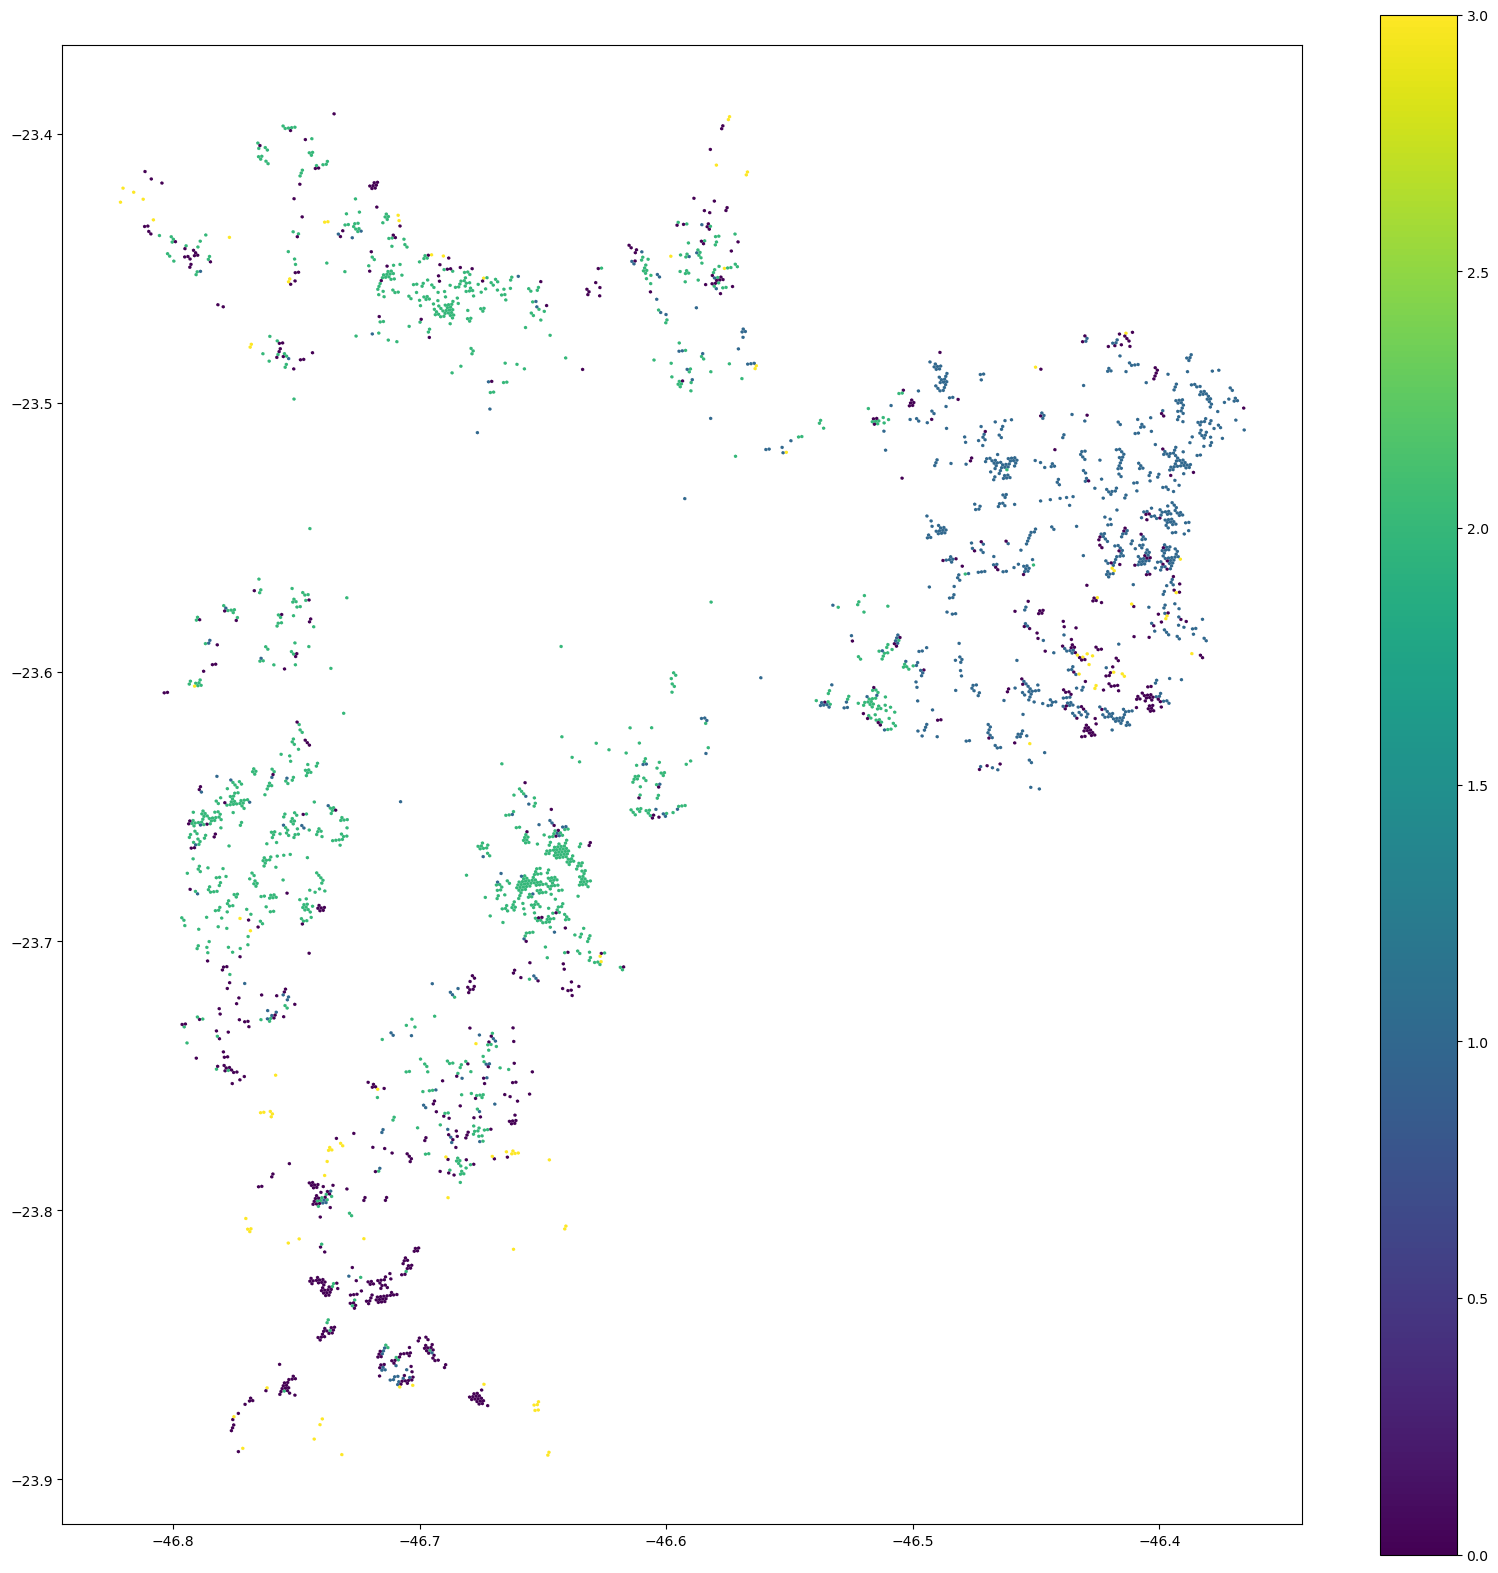

In [31]:
# plot a cloropleth map with the clusters
df_postives_FP.plot(column='cluster', legend=True, figsize=(20, 20), cmap='viridis')
